# EDA

In [1]:
import pandas as pd

In [2]:
raw = pd.read_csv('extracted_data.csv')

In [3]:
raw.head()

,nazev,url,rozmery,cena,tagy
0,"Plovdivská, Praha - Modřany",/nemovitosti-byty-domy/646866-nabidka-prodej-b...,"Prodej bytu 3+kk, 85 m²",7.590.000 Kč,MHD 3 minuty pěšky \r\n \r\nČástečně vybaveno ...
1,Praha - Ďáblice,/nemovitosti-byty-domy/652432-nabidka-prodej-b...,"Prodej bytu 2+kk, 50 m²",4.700.000 Kč,MHD do minuty pěšky \r\n \r\nVybaveno \r\n \r\...
2,"Konviktská, Praha - Staré Město",/nemovitosti-byty-domy/642660-nabidka-prodej-b...,"Prodej bytu 3+1, 74 m²",8.990.000 Kč,MHD 5 minut pěšky \r\n \r\nVybaveno \r\n \r\nT...
3,"U Průhonu, Praha - Holešovice",/nemovitosti-byty-domy/654099-nabidka-prodej-b...,"Prodej bytu 2+kk, 56 m²",6.590.000 Kč,MHD 1 minuta pěšky \r\n \r\nČástečně vybaveno ...
4,"Jinočany, Středočeský kraj",/nemovitosti-byty-domy/656099-nabidka-prodej-bytu,"Prodej bytu 1+kk, 35 m²",4.000.000 Kč,MHD 6 minut pěšky \r\n \r\nVybaveno \r\n \r\nV...


In [4]:
raw.tail()

,nazev,url,rozmery,cena,tagy
105,"Herejkova, Starý Plzenec, Plzeňský kraj",/nemovitosti-byty-domy/655753-nabidka-prodej-b...,"Prodej bytu 2+kk, 37 m²",1.800.000 Kč,MHD do minuty pěšky \r\n \r\nVybaveno \r\n \r\...
106,"Spořická, Praha - Dolní Chabry",/nemovitosti-byty-domy/654707-nabidka-prodej-b...,"Prodej bytu 3+kk, 84 m²",8.495.000 Kč,MHD do minuty pěšky \r\n \r\nVybaveno \r\n \r\...
107,"Ve Smečkách, Praha - Nové Město",/nemovitosti-byty-domy/654705-nabidka-prodej-b...,"Prodej bytu 2+kk, 58 m²",9.500.000 Kč,MHD 3 minuty pěšky \r\n \r\nVybaveno \r\n \r\n...
108,Praha - Vinohrady,/nemovitosti-byty-domy/655219-nabidka-prodej-bytu,"Prodej bytu 4+kk, 120 m²",16.380.840 Kč,MHD 1 minuta pěšky \r\n \r\nVybaveno \r\n
109,"Petržílkova, Praha - Stodůlky",/nemovitosti-byty-domy/655737-nabidka-prodej-b...,"Prodej bytu 2+kk, 43 m²",4.990.000 Kč,MHD do minuty pěšky \r\n \r\nČástečně vybaveno...


In [5]:
raw.shape

(110, 5)

In [6]:
raw.isna().sum()

nazev      0
url        0
rozmery    0
cena       0
tagy       0
dtype: int64

In [7]:
df = raw.copy()

# FEATURE ENG

In [8]:
import re

def getDispositions(row):
    dispozice = re.search(r'\d[+][\w]+', row)
    return dispozice.group(0) if dispozice else ""

df['dispozice'] = df['rozmery'].apply(getDispositions)

In [9]:
def getMeters(row):
    metraz = row.split(',')[-1].strip()
    metry_cislo = re.search(r'\d+', metraz)
    return int(metry_cislo.group(0)) if metry_cislo else ""


df['metraz'] = df['rozmery'].apply(getMeters)

df.drop(['rozmery'], inplace = True, axis = 1)

In [10]:
def fixPrice(row):
    cut_currency =  row.split(' ')[0]
    return int(cut_currency.replace('.', '').strip())

df['cena'] = df['cena'].apply(fixPrice)

In [11]:
def getMHD(row):
    just_mhd_info = row.split(' \r')[0]
    minutes = re.search(r'\d', just_mhd_info)
    return minutes.group(0) if minutes else 1

df['mhd'] = df['tagy'].apply(getMHD)

In [12]:
def tokenizeTags(row):
    tokens = row.split(' \r\n \r\n')
    tokens[-1] = tokens[-1].replace(' \r\n ', '').strip()
    tokens = tokens[1:] #dat pryc mhd
    return tokens

df['tagy_tokenized'] = df['tagy'].apply(tokenizeTags)
df.drop(columns = ['tagy'], inplace = True)

In [13]:
def getRegion(row):
    if 'kraj' in str(row):
        kraj = re.search(r'[a-zA-Zá-žÁ-Ž]* kraj', row)
        kraj = kraj.group(0) if kraj else ""
    else:
        kraj = re.search(r'Praha - [a-zA-Zá-žÁ-Ž ]*', row)
        kraj = kraj.group(0) if kraj else ""
        kraj = kraj.split(' - ')[-1]
    return kraj

df['kraj'] = df['nazev'].apply(getRegion)

In [14]:
df = df[~df['kraj'].str.contains("kraj")]

In [15]:
df_2 = pd.get_dummies(df['kraj'],drop_first=True)
df = df.merge(df_2, right_index = True, left_index = True, how = 'left')

# MODELLING

In [16]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

tokens = pd.DataFrame(mlb.fit_transform(df['tagy_tokenized']), columns = mlb.classes_, index = df.index)
df = df.merge(tokens, right_index = True, left_index = True, how = 'left').drop(columns = ['tagy_tokenized'])

In [17]:
from sklearn.preprocessing import OneHotEncoder

# which cols to drop - aren't useful features 
cols_not_features = ['nazev', 'url', 'kraj']
features = df.loc[:,~df.columns.isin(cols_not_features)]

In [18]:
from sklearn.preprocessing import OneHotEncoder

# which cols to drop - aren't useful features 
cols_not_features = ['nazev', 'url', 'kraj', 'dispozice']
features = df.loc[:,~df.columns.isin(cols_not_features)]

# one hot encode one variable
#enc = OneHotEncoder()
#dispozice_encoded = enc.fit_transform(features[['dispozice']])
#dispozice_encoded = pd.DataFrame(dispozice_encoded.toarray(), columns = enc.categories_)

# create final df
#features = features.drop(columns = ['dispozice'])
#dispozice_encoded = dispozice_encoded.set_index(df.index)
#features = pd.concat([features, dispozice_encoded], axis=1)

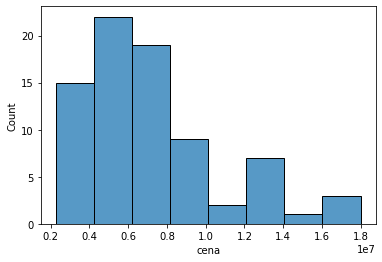

In [26]:
import seaborn as sns

sns.histplot(data=features, x = 'cena');

In [27]:
features = features.drop([features.index[features.cena.argmax()]])

In [28]:
features.head()

,cena,metraz,mhd,Chodov,Dejvice,Dolní Chabry,Hlubočepy,Holešovice,Háje,Jinonice,...,Žižkov,Balkón,Garáž,Lodžie,Parkování,Sklep,Terasa,Vybaveno,Výtah,Částečně vybaveno
0,7590000,85,3,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,1
1,4700000,50,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
2,8990000,74,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,6590000,56,1,0,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,1,1
5,13400000,86,4,0,0,0,0,0,0,1,...,0,1,0,0,1,1,0,1,1,0


In [29]:
stratify = pd.qcut(features['cena'], 5)

In [30]:
from sklearn.model_selection import train_test_split

y = features['cena']
X = features.drop(columns = ['cena'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, stratify = stratify)


In [31]:
print('Train X shape:' + str(X_train.shape))
print('Train y shape:' + str(y_train.shape))
print('Test X shape:' + str(X_test.shape))
print('Test y shape:' + str(y_test.shape))

Train X shape:(61, 42)
Train y shape:(61,)
Test X shape:(16, 42)
Test y shape:(16,)


In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

scaler = StandardScaler()
rfr = RandomForestRegressor(random_state=42, n_estimators = 500)

pipe = Pipeline(steps=[('scaler', scaler),('rfr', rfr)])

pipe.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('rfr',
                 RandomForestRegressor(n_estimators=500, random_state=42))])

In [33]:
from sklearn.metrics import mean_squared_error

y_predicted_train = pipe.predict(X_train)

mean_squared_error(y_train, y_predicted_train, squared = False)

662812.118568725

In [34]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score

elastic = ElasticNet(random_state = 42)

pipe_lr = Pipeline(steps=[('scaler', scaler),('elastic', elastic)])

pipe_lr.fit(X_train, y_train)

y_predicted_train_lr = pipe_lr.predict(X_train)

mean_squared_error(y_train, y_predicted_train_lr, squared = False), r2_score(y_train, y_predicted_train)

(1364268.6102250365, 0.9647139985217562)

In [35]:
y_predicted_test = pipe.predict(X_test)
y_predicted_test_lr = pipe_lr.predict(X_test)

mean_squared_error(y_test, y_predicted_test, squared = False), mean_squared_error(y_test, y_predicted_test_lr, squared = False), 

(1531417.8589665454, 1778612.7564603887)

# PREDICTIONS

In [36]:
df_with_predictions = X_train.copy()
df_with_predictions['predikovana_cena'] = y_predicted_train
df_with_predictions['aktualni_cena'] = y_train
df_with_predictions = df_with_predictions.merge(raw[['nazev', 'url', 'rozmery']], 
                                                how = 'inner', right_index = True, left_index = True)

In [37]:
df_with_predictions_test = X_test.copy()
df_with_predictions_test['predikovana_cena'] = y_predicted_test
df_with_predictions_test['aktualni_cena'] = y_test
df_with_predictions_test = df_with_predictions_test.merge(raw[['nazev', 'url', 'rozmery']], 
                                                          how = 'inner', right_index = True, left_index = True)

In [38]:
df_with_predictions_final = df_with_predictions.append(df_with_predictions_test)
assert(len(df_with_predictions)+len(df_with_predictions_test) == len(df_with_predictions_final))

In [39]:
df_with_predictions_final['odhad_minus_realita'] = df_with_predictions_final['predikovana_cena'] 
- df_with_predictions_final['aktualni_cena']
df_ = df_with_predictions_final.sort_values(by = 'odhad_minus_realita', ascending = False)
df = df_[['nazev', 'predikovana_cena', 'aktualni_cena', 'url', 'rozmery', 'odhad_minus_realita']][:10]

# WHICH TO BUY?

In [40]:
def whichToBuy(how_many_realties, open_tabs = True):
    import webbrowser as wb
    df = df_[['nazev', 'predikovana_cena', 'aktualni_cena', 'url', 'rozmery', 'odhad_minus_realita']][:how_many_realties]
    urls = []
    for _, flat in df.iterrows():
        url = 'https://bezrealitky.cz' + flat['url']
        urls.append(url)
    if open_tabs:
        for url in urls:
            wb.open(url)
    else:
        for i, url in enumerate(urls):
            print(url,'\n', df['nazev'].iloc[i],'---', df['aktualni_cena'].iloc[i], 'Kč', '---', df['rozmery'].iloc[i])

In [41]:
# PRINTS URL, LOCATION, PRICE, PROPERTY SIZE

whichToBuy(10, False)

https://bezrealitky.cz/nemovitosti-byty-domy/655000-nabidka-prodej-bytu-stefanikova-hlavni-mesto-praha 
 Štefánikova, Praha - Smíchov --- 16590000 Kč --- Prodej bytu 3+kk, 123 m² 
https://bezrealitky.cz/nemovitosti-byty-domy/654993-nabidka-prodej-bytu-stefanikova-hlavni-mesto-praha 
 Štefánikova, Praha - Smíchov --- 15950000 Kč --- Prodej bytu 3+kk, 117 m² 
https://bezrealitky.cz/nemovitosti-byty-domy/655219-nabidka-prodej-bytu 
 Praha - Vinohrady --- 16380840 Kč --- Prodej bytu 4+kk, 120 m² 
https://bezrealitky.cz/nemovitosti-byty-domy/631491-nabidka-prodej-bytu-stredni-praha 
 Střední, Praha - Veleslavín --- 13900000 Kč --- Prodej bytu 6+kk, 137 m² 
https://bezrealitky.cz/nemovitosti-byty-domy/654997-nabidka-prodej-bytu-stefanikova-hlavni-mesto-praha 
 Štefánikova, Praha - Smíchov --- 12790000 Kč --- Prodej bytu 4+kk, 96 m² 
https://bezrealitky.cz/nemovitosti-byty-domy/449267-nabidka-prodej-bytu-krocinova-praha-stare-mesto 
 Krocínova, Praha - Staré Město --- 13490000 Kč --- Prodej b

In [163]:
# OPENS TABS WITH REALTIES

whichToBuy(5, True)